# Visualization of Topic Summaries and Article Summaries

In [76]:
from pathlib import Path
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 解析单个 html
def parse_html(path):
    with open(path, encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'lxml')

    # 1.1 Topic-Summary
    label = soup.find('div', class_='container').find('h1').get_text()

    topic_summary = soup.find('div', class_='summary-content').get_text()

    # 1.2 Source-Articles
    articles = []
    for card in soup.select('div.article-card'):
        title = card.select_one('.article-title a').get_text(strip=True)
        content = card.select_one('.article-content').get_text(strip=True)
        articles.append(title + ' ' + content)

    return topic_summary, articles, label



In [77]:
topic_summary, articles, label = parse_html('./html/Tesla.html')

In [78]:
topic_summary

'Tesla faces significant challenges in 2025 amid declining sales, political controversies, and regulatory scrutiny, while Elon Musk secures a historic $1 trillion performance-based pay package from shareholders. Despite these headwinds, investor confidence remains strong due to Musk’s vision of transforming Tesla into an AI and robotics leader.\n\n1. In October 2025, Tesla’s China sales fell 35.8% year-on-year to 26,006 vehicles—the lowest in three years—while its market share dropped to 3.2%. European sales also declined sharply, with a 40% drop in Germany.\n\n2. On November 6, 2025, over 75% of Tesla shareholders approved a pay package granting Musk up to 423.7 million shares if Tesla reaches a $8.5 trillion market cap and meets aggressive targets, including selling 20 million vehicles and deploying one million robotaxis and robots.\n\n3. Tesla reported a 37% year-on-year profit decline in Q3 2025 despite record revenue of $28.1 billion, driven by last-minute purchases before the U.S

In [79]:
label

'Tesla Musk Pay Package'

In [80]:
len(articles)

39

In [81]:
articles[0]

'Tesla’s China sales fall to 3-year low amid tepid demand Tesla’s(TSLA.O)sales in China dropped to 26,006 vehicles in October, their lowest in three years, as the US electric vehicle maker struggles with tepid demand in the hyper-competitive market. Sales fe...'

In [82]:
# 2. 批量解析
html_dir = Path('html')          # 存放所有 html 的目录
records = []                      # 每个元素：(text, label, html_id, role)
for idx, html in enumerate(html_dir.glob('*.html')):
    summary, arts, lab = parse_html(html)
    records.append((summary, lab, 'topic'))
    for art in arts:
        records.append((art, lab, 'article'))

df = pd.DataFrame(records, columns=['text', 'label', 'role'])


In [83]:
df.label.unique()

array(['Zootopia 2 Release', 'Tesla Musk Pay Package'], dtype=object)

In [167]:
# 3. TF-IDF 向量化
tfidf = TfidfVectorizer(stop_words='english', norm='l2')
X = tfidf.fit_transform(df.text).toarray()  + 1e-10     # scipy sparse matrix
y = df.label.values


In [168]:
len(tfidf.vocabulary_)

921

In [132]:
from matplotlib.markers import MarkerStyle

def scatter_with_center(embed, title):
    fontsize = 20
    S = 80
    plt.figure(figsize=(8, 8), dpi=100)

    uniq = np.unique(y)
    palette = sns.color_palette('tab10', n_colors=len(uniq))
    color_map = dict(zip(uniq, palette))

    # 1. 先画所有散点（背景点）
    for lab in uniq:
        mask = y == lab
        plt.scatter(embed[mask, 0], embed[mask, 1],
                    c=[color_map[lab]], label=lab, s=S, alpha=.6)

    # 2. 给 topic 实例画彩色星星 + 文字
    topic_mask = df.role == 'topic'
    for idx_in_df in np.where(topic_mask)[0]:
        lab   = y[idx_in_df]
        x, y_coord = embed[idx_in_df]
        col = color_map[lab]

        # 画星
        plt.scatter(x, y_coord,
                    marker=MarkerStyle('*'),   # 五角星
                    s=280,                      # 星星大小
                    c=[col], edgecolors='black', linewidths=.6)

        # 文字稍微偏移
        topic_text = df.label.iloc[idx_in_df]
        short = (topic_text[:80] + '...') if len(topic_text) > 80 else topic_text
        plt.text(x + 0.05, y_coord + 0.05, short,
                 fontsize=fontsize,
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    plt.grid(True)
    plt.title(title, fontsize=fontsize)
    # plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

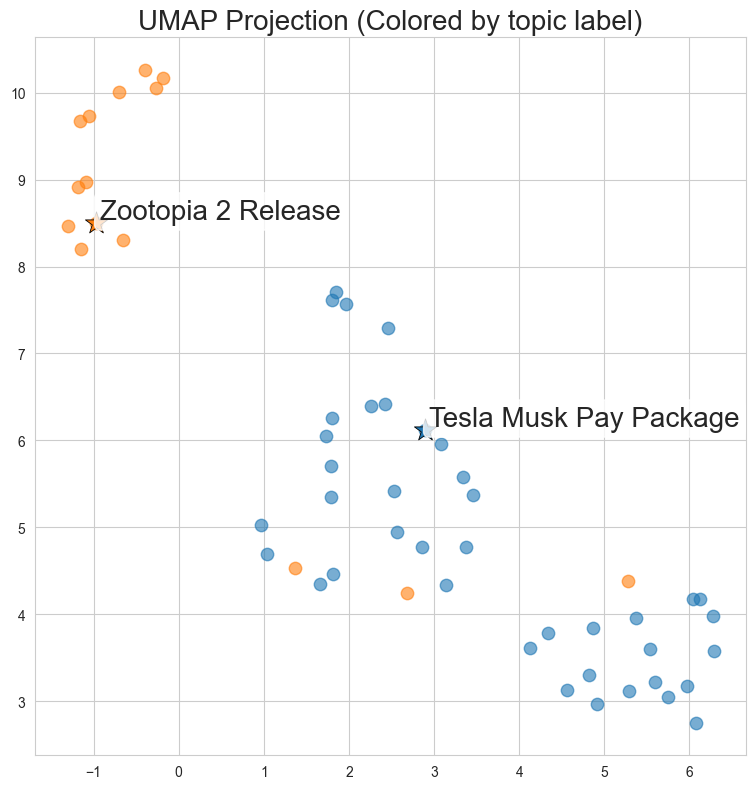

In [178]:
# 4.1 UMAP
umap_em = umap.UMAP(n_neighbors=5).fit_transform(X)
scatter_with_center(umap_em, 'UMAP Projection (Colored by topic label)')


In [154]:
X.shape

(55, 921)

/var/folders/82/tr0t3jp906z8k_q9pbcg_jd40000gn/T/ipykernel_42034/1782062018.py:1: RuntimeWarning: divide by zero encountered in matmul
  sns.heatmap(X @ X.T)
/var/folders/82/tr0t3jp906z8k_q9pbcg_jd40000gn/T/ipykernel_42034/1782062018.py:1: RuntimeWarning: overflow encountered in matmul
  sns.heatmap(X @ X.T)
/var/folders/82/tr0t3jp906z8k_q9pbcg_jd40000gn/T/ipykernel_42034/1782062018.py:1: RuntimeWarning: invalid value encountered in matmul
  sns.heatmap(X @ X.T)


<Axes: >

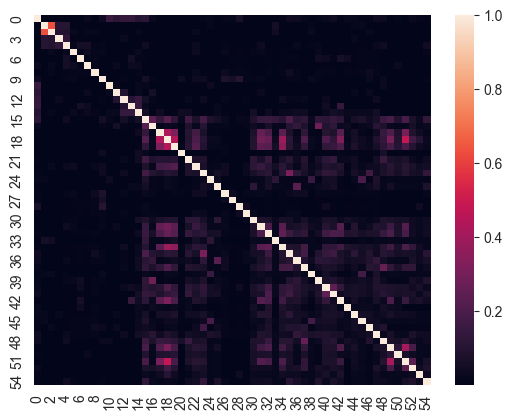

In [170]:
sns.heatmap(X @ X.T)

<Axes: >

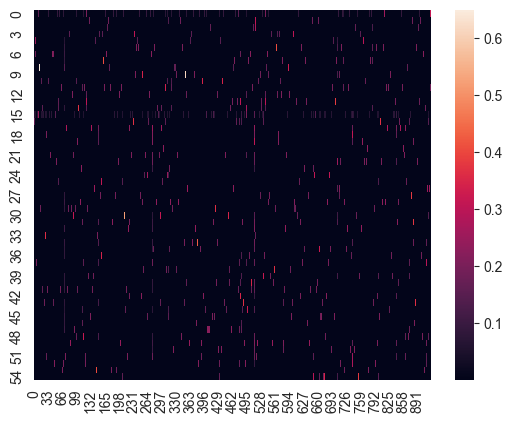

In [171]:
sns.heatmap(X)

/Users/fengcong/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/fengcong/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/fengcong/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/fengcong/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/fengcong/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/fengcong/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalize

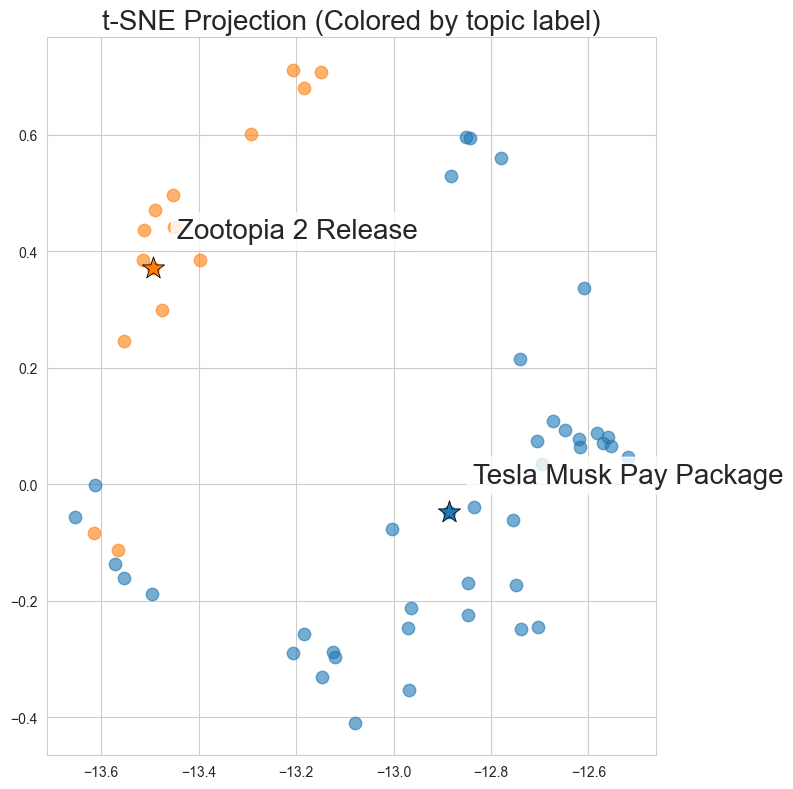

In [174]:
# 4.2 t-SNE
tsne_em = TSNE(n_components=2, metric='cosine', perplexity=50).fit_transform(X)
scatter_with_center(tsne_em, 't-SNE Projection (Colored by topic label)')